In [23]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# PART I - data collection

### Ежемесячный спрос на новые автомобили по РФ с 2006-2022гг.

Источник: https://auto.vercity.ru/statistics/sales/europe/russia/ .

In [24]:
demand_df = pd.read_excel('data_time_series/demand_for_new_cars.xlsx')

demand_df = pd.melt(demand_df, id_vars=['Year'])\
    .rename({'variable': 'Month', 'value': 'demand_new'}, axis=1)
demand_df['Month'] = pd.to_datetime(demand_df['Month'], format='%B').dt.month
demand_df['date'] = pd.to_datetime(demand_df[['Year', 'Month']].assign(DAY=1))
demand_df = demand_df[['date', 'demand_new']].sort_values(['date']).reset_index(drop=True)

# print(demand_df.tail(3))
demand_df = demand_df[:-1]

demand_df['demand_new'] = demand_df['demand_new'].apply(lambda x: x.replace(' ', '')).astype('int')

demand_df.iloc[[0, -1]]

,date,demand_new
0,2006-01-01,95253
202,2022-11-01,46403


### Индексы потребительских цен на непродовольственные товары по Российской Федерации в 1991-2022гг.

Источник: https://rosstat.gov.ru/statistics/price .

In [25]:
inf_df = pd.read_excel('data_time_series/inflation.xlsx')

inf_df = pd.melt(inf_df, id_vars=['month'])\
    .rename({'variable': 'year', 'value': 'inflation_rate'}, axis=1)
inf_df['date'] = pd.to_datetime(inf_df[['year', 'month']].assign(DAY=1))

inf_df = inf_df[['date', 'inflation_rate']].sort_values(['date']).reset_index(drop=True)

# print(inf_df.tail(3))
inf_df = inf_df[:-1]

inf_df['inflation_rate'] = inf_df['inflation_rate'].astype('float')

inf_df.iloc[[0, -1]]

,date,inflation_rate
0,1991-01-01,109.00
382,2022-11-01,100.06


### Ежемесячные цены на нефть марки BRENT в USD по 2005-2023гг.

Да, в России преимущественным сортом нефти является URALS, но статистику ежемесячных цен с 2006 года я не смог найти, однако URALS имеет очень высокую корреляцию с BRENT, поэтому такая замещающая представительная переменная тоже подойдет.

Источник: https://www.finam.ru/profile/tovary/brent/export/ .

In [26]:
brent_df = pd.read_csv('data_time_series/ICE.BRN_050101_230109.txt')

brent_df = brent_df[['<DATE>', '<CLOSE>']].rename({'<DATE>': 'date', '<CLOSE>': 'brent_close_price'}, axis=1)
brent_df['date'] = pd.to_datetime(brent_df['date'], format='%Y%m%d')

brent_df.iloc[[0, -1]]

,date,brent_close_price
0,2005-01-01,45.87
216,2023-01-01,79.45


### Индикаторы инфляции: цены на марки бензина 92, 95, цены на муниципальный транспорт 2006-2022гг.

Очень высокая корреляция, в результате выбраны цены на 95, как на наиболее распространенный (преобладающий в приобретении).

Источник: https://www.fedstat.ru/indicator/31326 .

In [27]:
pp_df = pd.read_excel('data_time_series/purchasing_power.xlsx')

pp_df.columns = ['year', 'Product', 'Russia']

pp_df['year'] = pp_df['year'].fillna(method='ffill').astype('int')
pp_df = pp_df[pp_df['year'] >= 2006]
pp_df = pp_df[pp_df['Product'] != 'Бензин']

pp_df = pp_df.pivot(index='year', columns='Product', values='Russia')
pp_df = pp_df.reset_index(drop=False)
pp_df.columns = ['year', 'pp_petrol_92', 'pp_petrol_95', 'pp_city_bus', 'pp_municipal_bus']

print(f"Correlation between petrol 92 and petrol 95: {pp_df[['pp_petrol_92', 'pp_petrol_95']].corr().iloc[0, 1].round(4)}")

pp_df = pp_df[['year', 'pp_petrol_95']]

def df_year_to_months(df_input):
    df = pd.concat([df_input for _ in range(12)]).sort_values('year').reset_index(drop=True)
    df['year'] = pd.to_datetime(df['year'], format='%Y')
    df['year'] = df.apply(lambda x: x['year'] + pd.DateOffset(months=x.name % 12), axis=1)
    df = df.rename({'year': 'date'}, axis=1)
    return df

pp_df = df_year_to_months(pp_df)

pp_df.iloc[[0, -1]]

Correlation between petrol 92 and petrol 95: 0.9985


,date,pp_petrol_95
0,2006-01-01,533.0
191,2021-12-01,818.4


### Пара USD/RUB 1995-2023гг.

Источник: https://stooq.com/q/d/?s=usdrub&c=0&o=1111111&i=m&o_s=1&o_d=1&o_p=1&o_n=1&o_o=1&o_m=1&o_x=1 .

In [28]:
usdrub_df = pd.read_csv('data_time_series/usdrub_m.csv')

usdrub_df = usdrub_df[['Date', 'Close']].rename({'Date': 'date', 'Close': 'usdrub_close_price'}, axis=1)

usdrub_df['date'] = pd.DatetimeIndex(usdrub_df['date']) + pd.DateOffset(1)

usdrub_df.iloc[[0, -1]]

,date,usdrub_close_price
0,1995-11-01,4.508
327,2023-02-01,72.770


### Реальный эффективный обменный курс для России [RBRUBIS] 1994-2022гг.

Источник: https://fred.stlouisfed.org/series/RBRUBIS .

In [29]:
rbrubis_df = pd.read_csv('data_time_series/RBRUBIS.csv')
rbrubis_df = rbrubis_df.rename({'DATE': 'date', 'RBRUBIS': 'rbrubis'}, axis=1)
rbrubis_df['date'] = pd.to_datetime(rbrubis_df['date'])

rbrubis_df.iloc[[0, -1]]

,date,rbrubis
0,1994-01-01,48.62
346,2022-11-01,110.31


### Индикаторы реального дохода, р. зарплаты, р. пенсии, индекс Джини по России 1991-2022гг.

Источник: https://rosstat.gov.ru/folder/210/document/13396 .

In [30]:
indicators_df = pd.read_excel('data_time_series/indicators.xlsx')

indicators_df = indicators_df.T.reset_index()
indicators_df.columns = ['year', 'real_income', 'real_wage', 'real_pension', 'Gini']
indicators_df = indicators_df.drop(0, axis=0).reset_index(drop=True)

indicators_df = df_year_to_months(indicators_df)

indicators_df.iloc[[0, -1]]

,date,real_income,real_wage,real_pension,Gini
0,1991-01-01,120.9,96.6,96.8,0.26
371,2021-12-01,103.2,104.5,104.1,0.409


## Объединение всех датафреймов по дате и сохранение

In [31]:
all_df = demand_df
other_dfs = [inf_df, brent_df, pp_df, usdrub_df, rbrubis_df, indicators_df]

for df_i in other_dfs:
    all_df = pd.merge(all_df, df_i)

del inf_df, brent_df, pp_df, usdrub_df, rbrubis_df, indicators_df
del other_dfs
gc.collect()

all_df.to_csv('data_time_series/all_df.csv', index=False, header=True)

# PART II - data processing

In [32]:
all_df = pd.read_csv('data_time_series/all_df.csv')

all_df = all_df.set_index(pd.to_datetime(all_df['date']))

for col in ['pp_petrol_95', 'real_income', 'real_wage', 'real_pension', 'Gini']:
    all_df[col] = all_df[col].rolling(12).mean().fillna(all_df[col])

all_df.iloc[[0, -1]]

,date,demand_new,inflation_rate,brent_close_price,pp_petrol_95,usdrub_close_price,rbrubis,real_income,real_wage,real_pension,Gini
date,,,,,,,,,,,
2006-01-01,2006-01-01,95253,100.41,65.43,533.0,28.7380,84.78,113.466448,113.3,105.1,0.415
2021-12-01,2021-12-01,140939,100.64,77.94,818.4,74.5025,79.58,103.200000,104.5,104.1,0.409


In [33]:
all_df[['real_income', 'real_wage', 'real_pension']].corr()

all_df.drop('real_wage', inplace=True, axis=1)

### Используемые переменные [матрица X для ARDL]:

In [34]:
features = ['inflation_rate', 'brent_close_price',
            'pp_petrol_95', 'usdrub_close_price',
            'rbrubis', 'real_income',
            'real_pension', 'Gini']

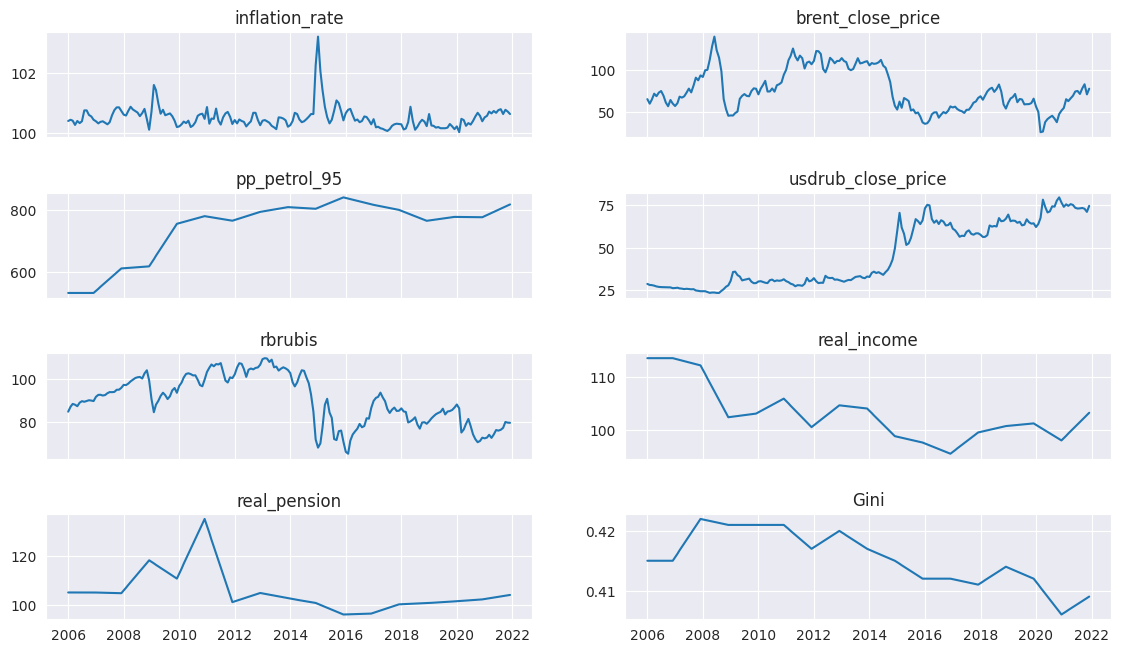

In [40]:
def show_features():
    figure, axis = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(12, 7))
    figure.tight_layout(pad=3.)

    for ij, col in zip(itertools.product(range(4), range(2)), features):
        axis[ij].plot(all_df.index, all_df[col])
        axis[ij].set_title(col)

    plt.show()

show_features()

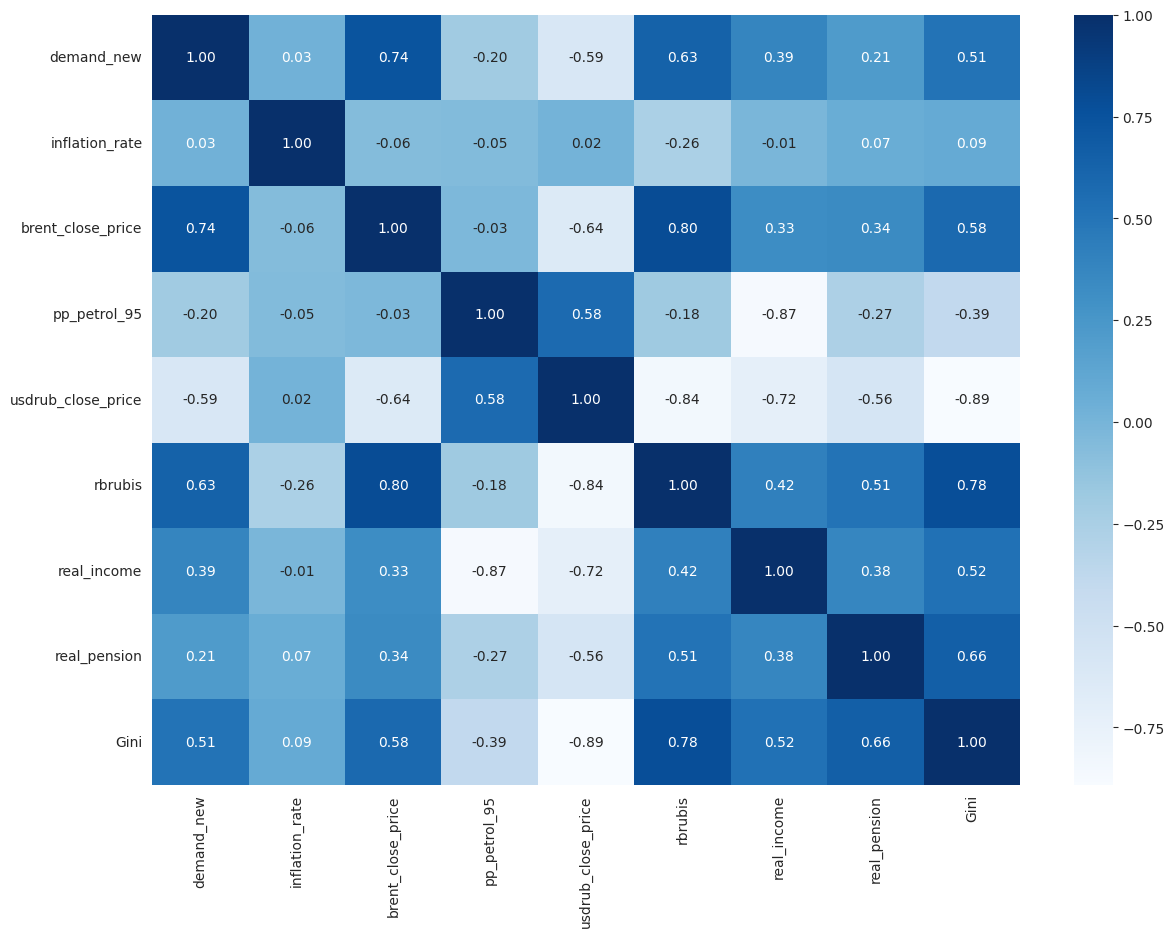

In [41]:
plt.rc('figure', figsize=(14, 10))
crr = all_df.corr()
sns.heatmap(crr, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.show()

<AxesSubplot: xlabel='date'>

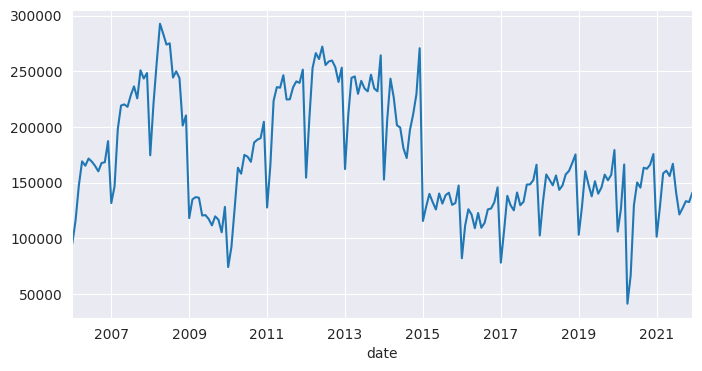

In [42]:
plt.rc('figure', figsize=(8, 4))
all_df['demand_new'].plot()

## Логарифмирование необходимых переменных

<AxesSubplot: xlabel='date'>

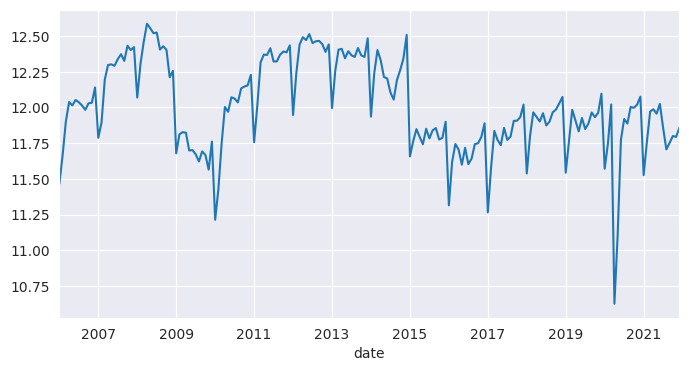

In [43]:
all_df['log_demand_new'] = np.log(all_df['demand_new'])

plt.rc('figure', figsize=(8, 4))
all_df['log_demand_new'].plot()

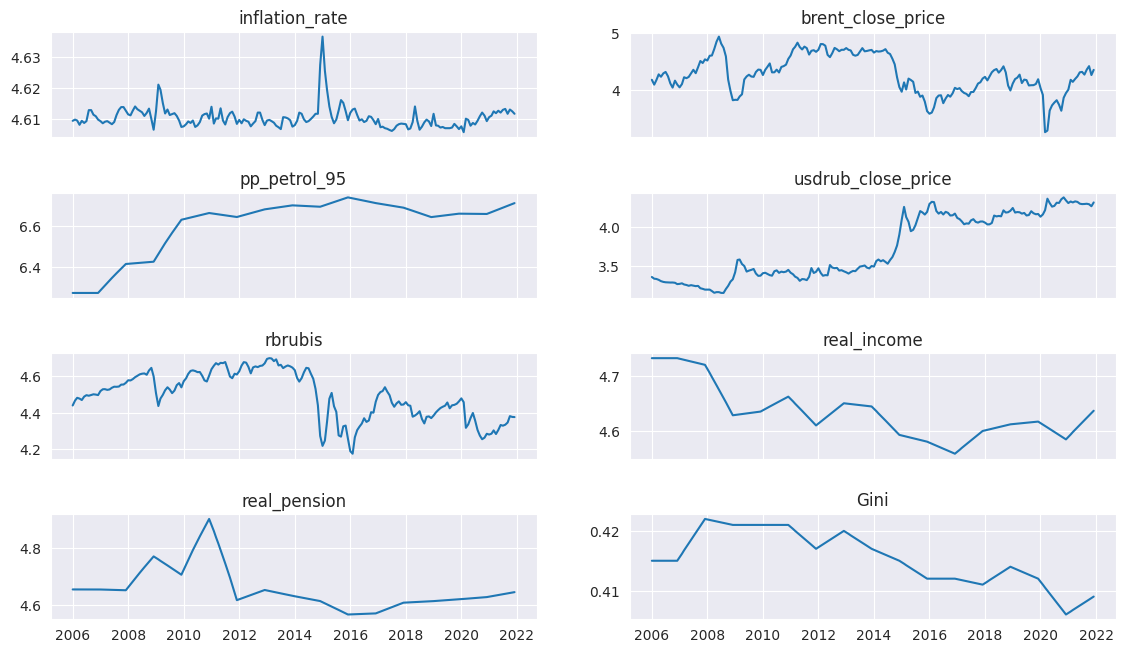

In [44]:
for ftr in features[:-1]:
    all_df[ftr] = np.log(all_df[ftr])

show_features()

## Изъятие сезонности из всех переменных

<AxesSubplot: xlabel='date'>

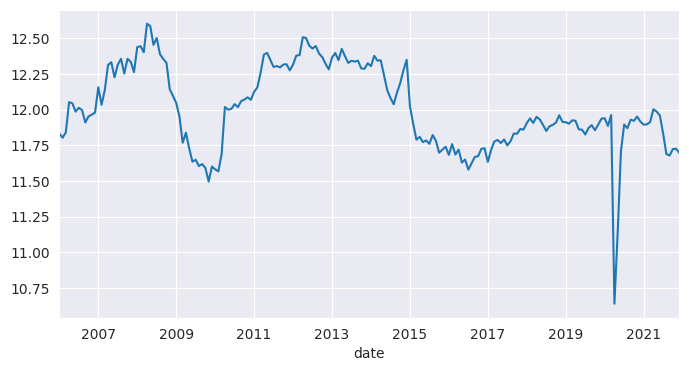

In [45]:
decompose_result = seasonal_decompose(all_df['log_demand_new'])
all_df['decompose_result_seasonal'] = decompose_result.seasonal

all_df['deseasonal_demand_new'] = all_df['log_demand_new'] - all_df['decompose_result_seasonal']

plt.rc('figure', figsize=(8, 4))
all_df['deseasonal_demand_new'].plot()

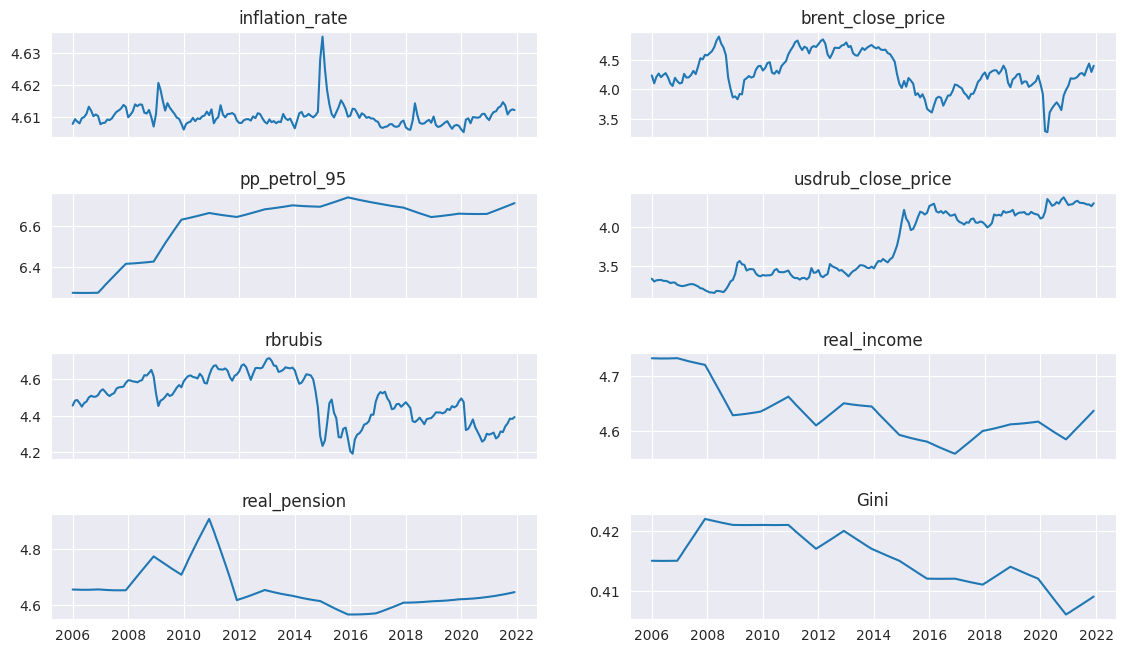

In [46]:
for ftr in features:
    all_df[ftr] = all_df[ftr] - seasonal_decompose(all_df[ftr]).seasonal

show_features()

### Тест на стационарность для объясняемой переменной

kpss-test P-value of TS itself: 2.230312%
kpss-test P-value of first differences: 10.000000%


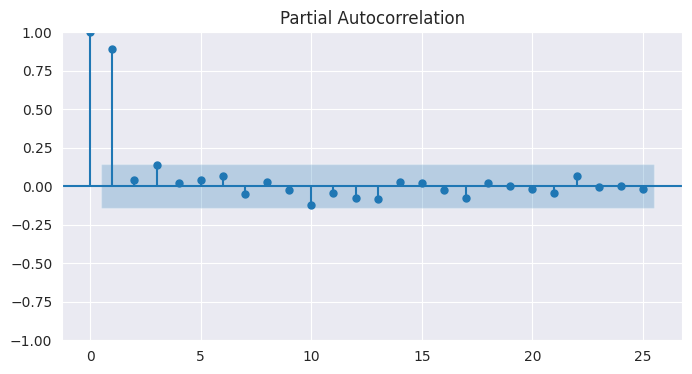

In [47]:
first_diff = all_df['deseasonal_demand_new'].diff(1)[1:]

print(f"kpss-test P-value of TS itself: {kpss(all_df['deseasonal_demand_new'])[1]:%}")
print(f"kpss-test P-value of first differences: {kpss(first_diff)[1]:%}")
# null hypothesis of the KPSS test: stationary TS
# p-value  > 0.05 - This implies that time-series is stationary.
# p-value <= 0.05 - This implies that time-series is non-stationary.

plot_pacf(all_df['deseasonal_demand_new'], lags=25, method='ywm')

plt.show()

## Взятие разностей (необходимого порядка) [или не взятие, если тест показал, что не нужно]

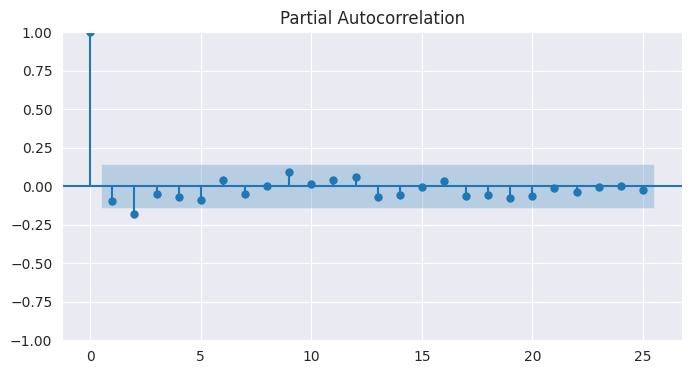

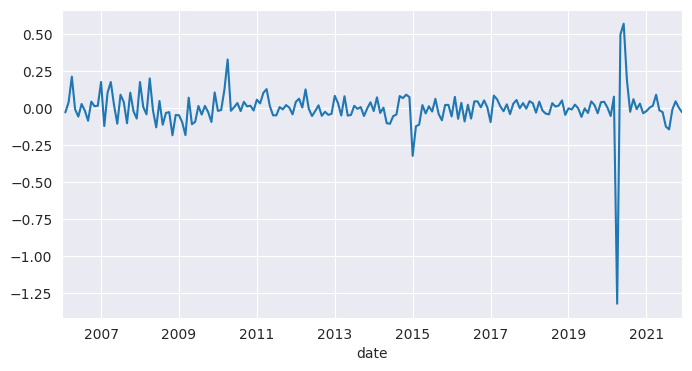

In [49]:
all_df['diffed_demand_new'] = all_df['deseasonal_demand_new'].diff(1)

plt.rc('figure', figsize=(8, 4))
plot_pacf(all_df['diffed_demand_new'][1:], lags=25, method='ywm')

plt.show()

plt.rc('figure', figsize=(8, 4))
all_df['diffed_demand_new'].plot()
plt.show()

Feature: [inflation_rate]: kpss-test's P-value of TS: 10.000000%, of 1-st diffs: 10.000000%, of 2-st diffs: 10.000000%
leave itself
Feature: [brent_close_price]: kpss-test's P-value of TS: 2.599138%, of 1-st diffs: 10.000000%, of 2-st diffs: 4.166667%
make 1-st diffs
Feature: [pp_petrol_95]: kpss-test's P-value of TS: 1.000000%, of 1-st diffs: 2.124653%, of 2-st diffs: 10.000000%
make 2-st diffs
Feature: [usdrub_close_price]: kpss-test's P-value of TS: 1.000000%, of 1-st diffs: 10.000000%, of 2-st diffs: 10.000000%
make 1-st diffs
Feature: [rbrubis]: kpss-test's P-value of TS: 1.000000%, of 1-st diffs: 10.000000%, of 2-st diffs: 10.000000%
make 1-st diffs
Feature: [real_income]: kpss-test's P-value of TS: 1.000000%, of 1-st diffs: 10.000000%, of 2-st diffs: 10.000000%
make 1-st diffs
Feature: [real_pension]: kpss-test's P-value of TS: 1.000000%, of 1-st diffs: 10.000000%, of 2-st diffs: 10.000000%
make 1-st diffs
Feature: [Gini]: kpss-test's P-value of TS: 1.000000%, of 1-st diffs: 10.

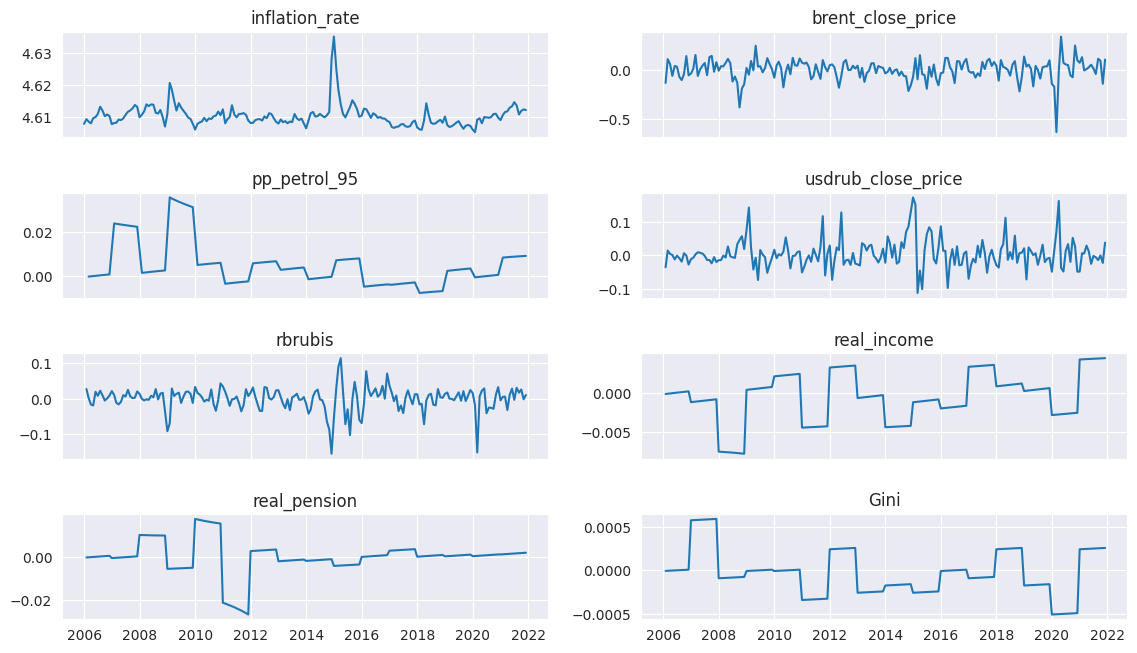

In [50]:
for ftr in features:
    kpss_ = kpss(all_df[ftr])[1]
    kpss_diff = kpss(all_df[ftr].diff(1)[1:])[1]
    kpss_diff2 = kpss(all_df[ftr].diff(1)[1:].diff(1)[1:])[1]

    print(f'Feature: [{ftr}]: kpss-test\'s P-value of TS: {kpss_:%}, of 1-st diffs: {kpss_diff:%}, of 2-st diffs: {kpss_diff2:%}')

    if kpss_ < 0.05:
        if kpss_diff > 0.05:
            all_df[ftr] = all_df[ftr].diff(1)
            print('make 1-st diffs')
        elif kpss_diff2 > 0.05:
            all_df[ftr] = all_df[ftr].diff(2)
            print('make 2-st diffs')
        else:
            print('something went wrong')
    else:
        print('leave itself')

show_features()

### Добавление фиктивной переменной, отвечающей за Covid-19

In [51]:
start_of_covid = all_df['deseasonal_demand_new'].sort_values(ascending=True).index[0]
all_df['covid'] = (all_df.index == start_of_covid).astype('int')

features.append('covid')

In [52]:
all_df.to_csv('data_time_series/all_df_ready.csv', index=False, header=True)

# PART III - model estimation

Модели оценивались (как ARIMA, так и ARDL) итерационно, с подбором наиболее подходящих параметров.

In [60]:
all_df = pd.read_csv('data_time_series/all_df_ready.csv')

all_df = all_df.set_index(pd.to_datetime(all_df['date']))

features = ['inflation_rate', 'brent_close_price',
            'pp_petrol_95', 'usdrub_close_price',
            'rbrubis', 'real_income',
            'real_pension', 'Gini', 'covid']

In [61]:
train = all_df.loc[all_df.index < pd.to_datetime('2021-01-01'), :][2:]
test = all_df.loc[all_df.index >= pd.to_datetime('2021-01-01'), :]

## I. ARIMA

In [62]:
ts_train = train['diffed_demand_new']
ts_test = test['diffed_demand_new']

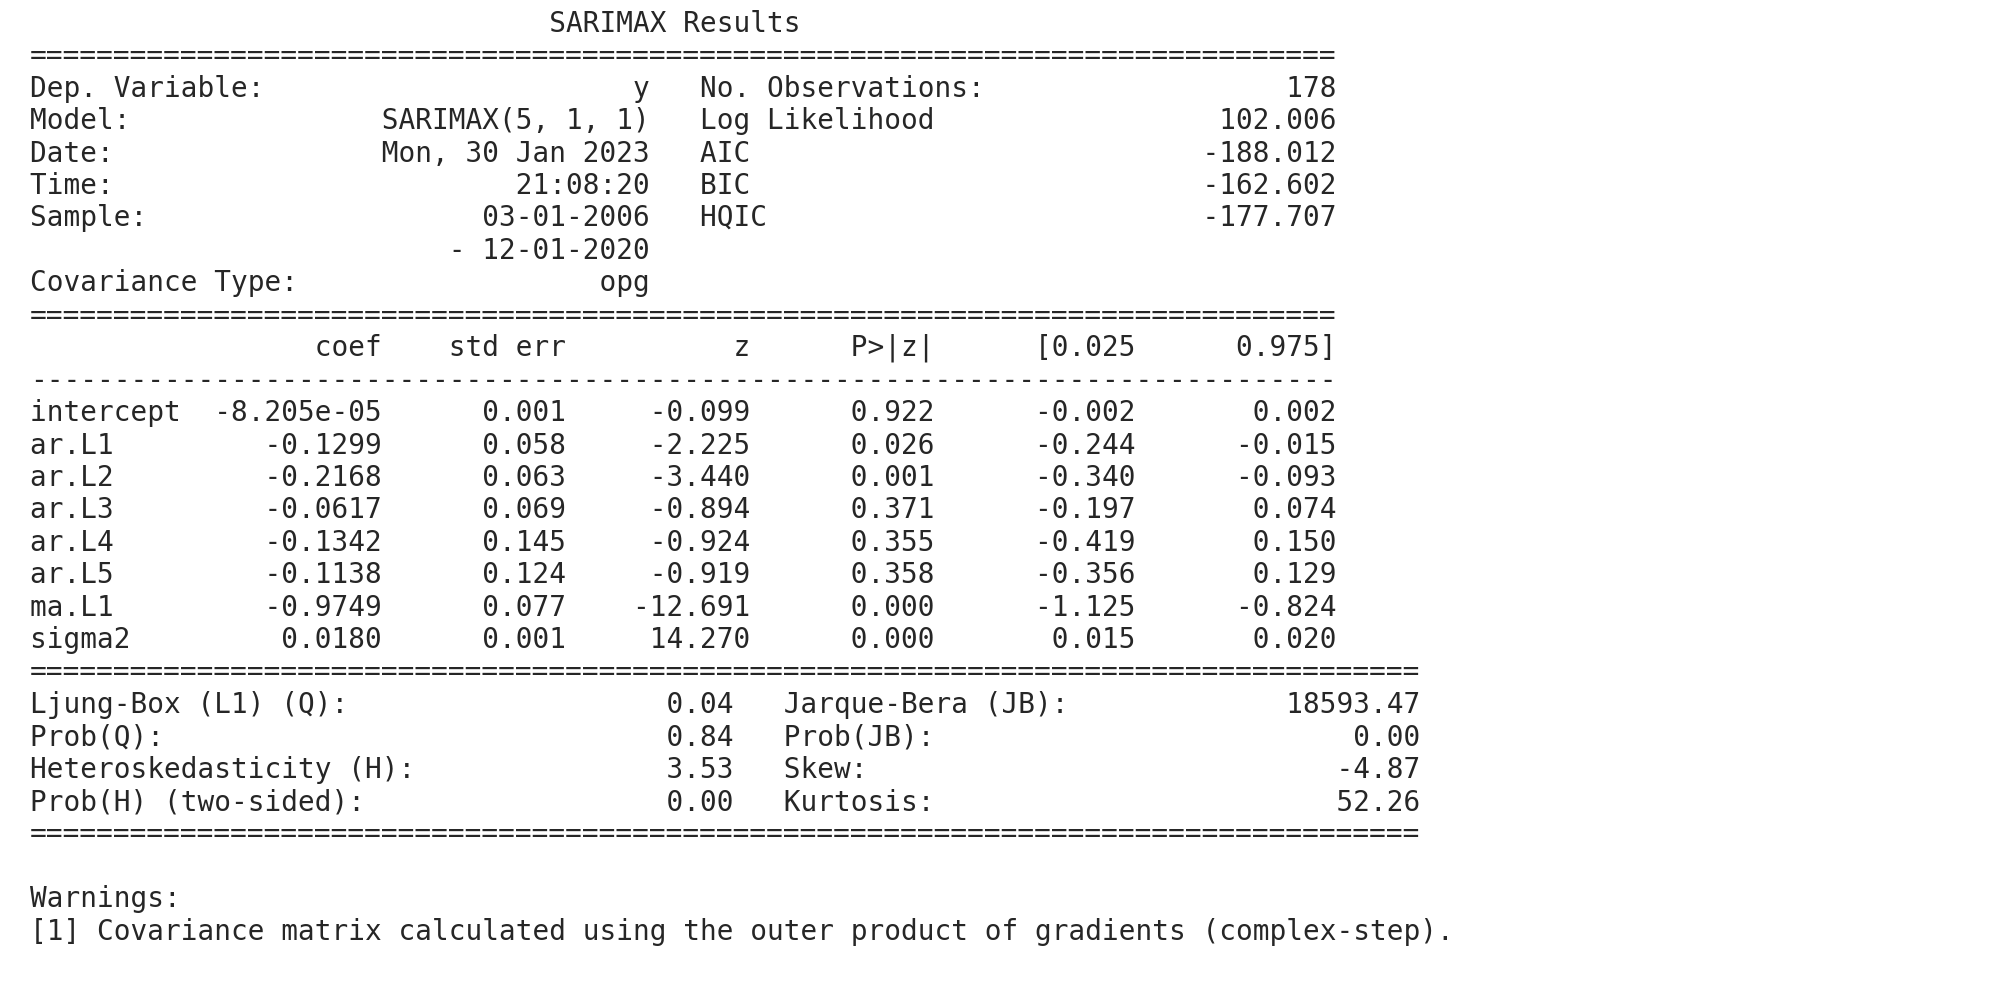

In [82]:
import pmdarima as pm

# AIC
model = pm.auto_arima(ts_train,
                      d=1,
                      start_p=1, start_q=1, max_p=12, max_q=12,
                      information_criterion='aic',
                      seasonal=False, m=0,
                      trace=False,
                      random_state=42)

plt.rc('figure', figsize=(20, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 20}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()

plt.show()
#  sigma2 [squared] represents the variance of the residual values.
#  This value is used to test the normality of residuals against the alternative of non-normality.

In [83]:
train_pred = model.fittedvalues()
test_pred = model.predict(len(ts_test))

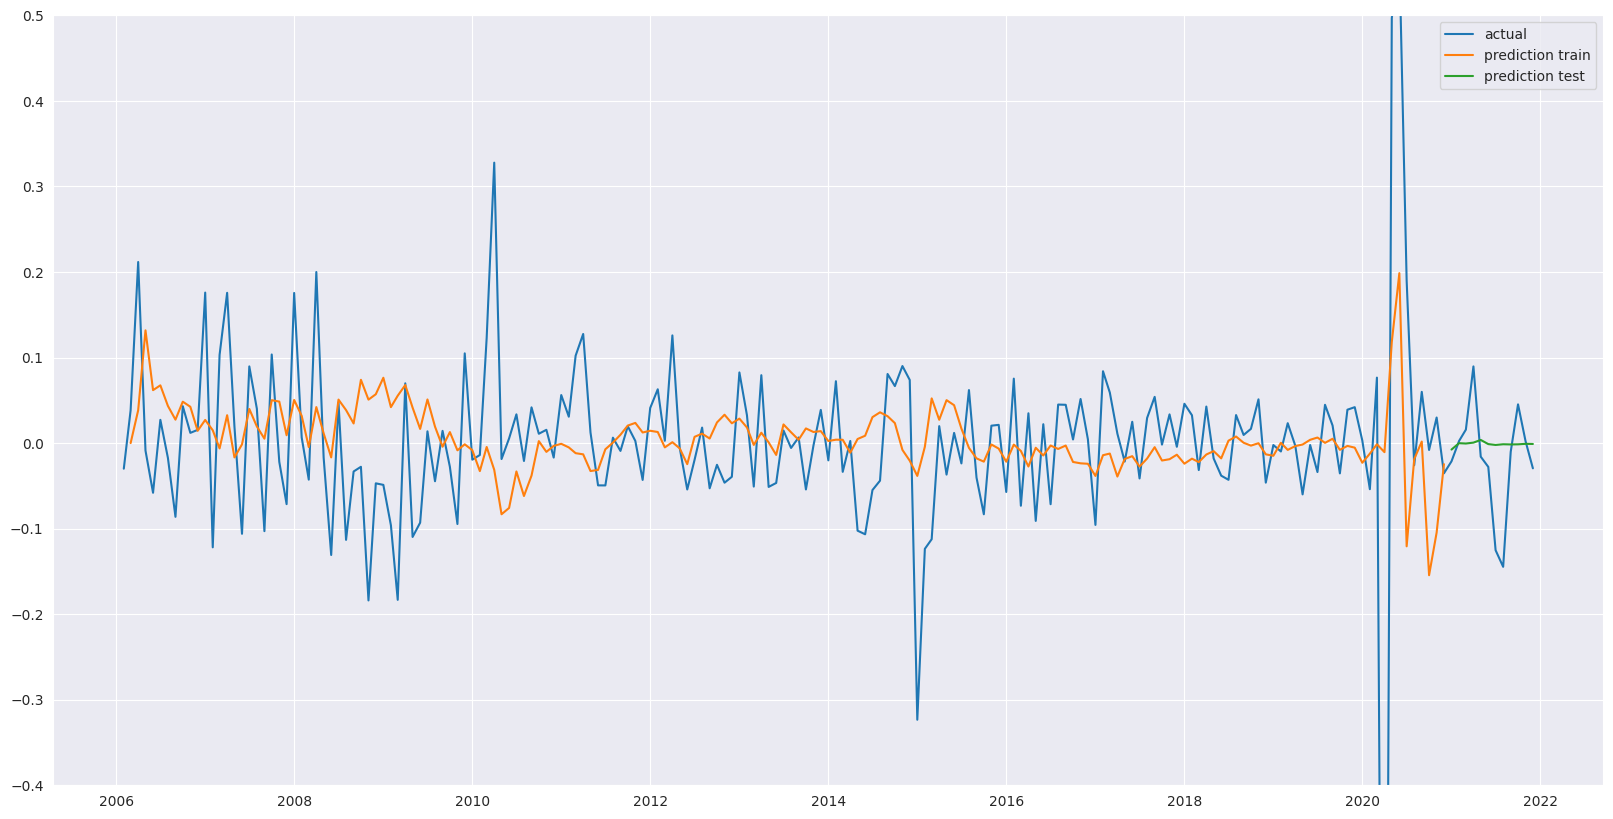

In [84]:
plt.plot(all_df.index, all_df['diffed_demand_new'], label="actual")
plt.plot(train.index, train_pred, label="prediction train")
plt.plot(test.index, test_pred, label="prediction test")
plt.legend()
plt.ylim(-0.4, 0.5)

plt.show()

## II. ARDL

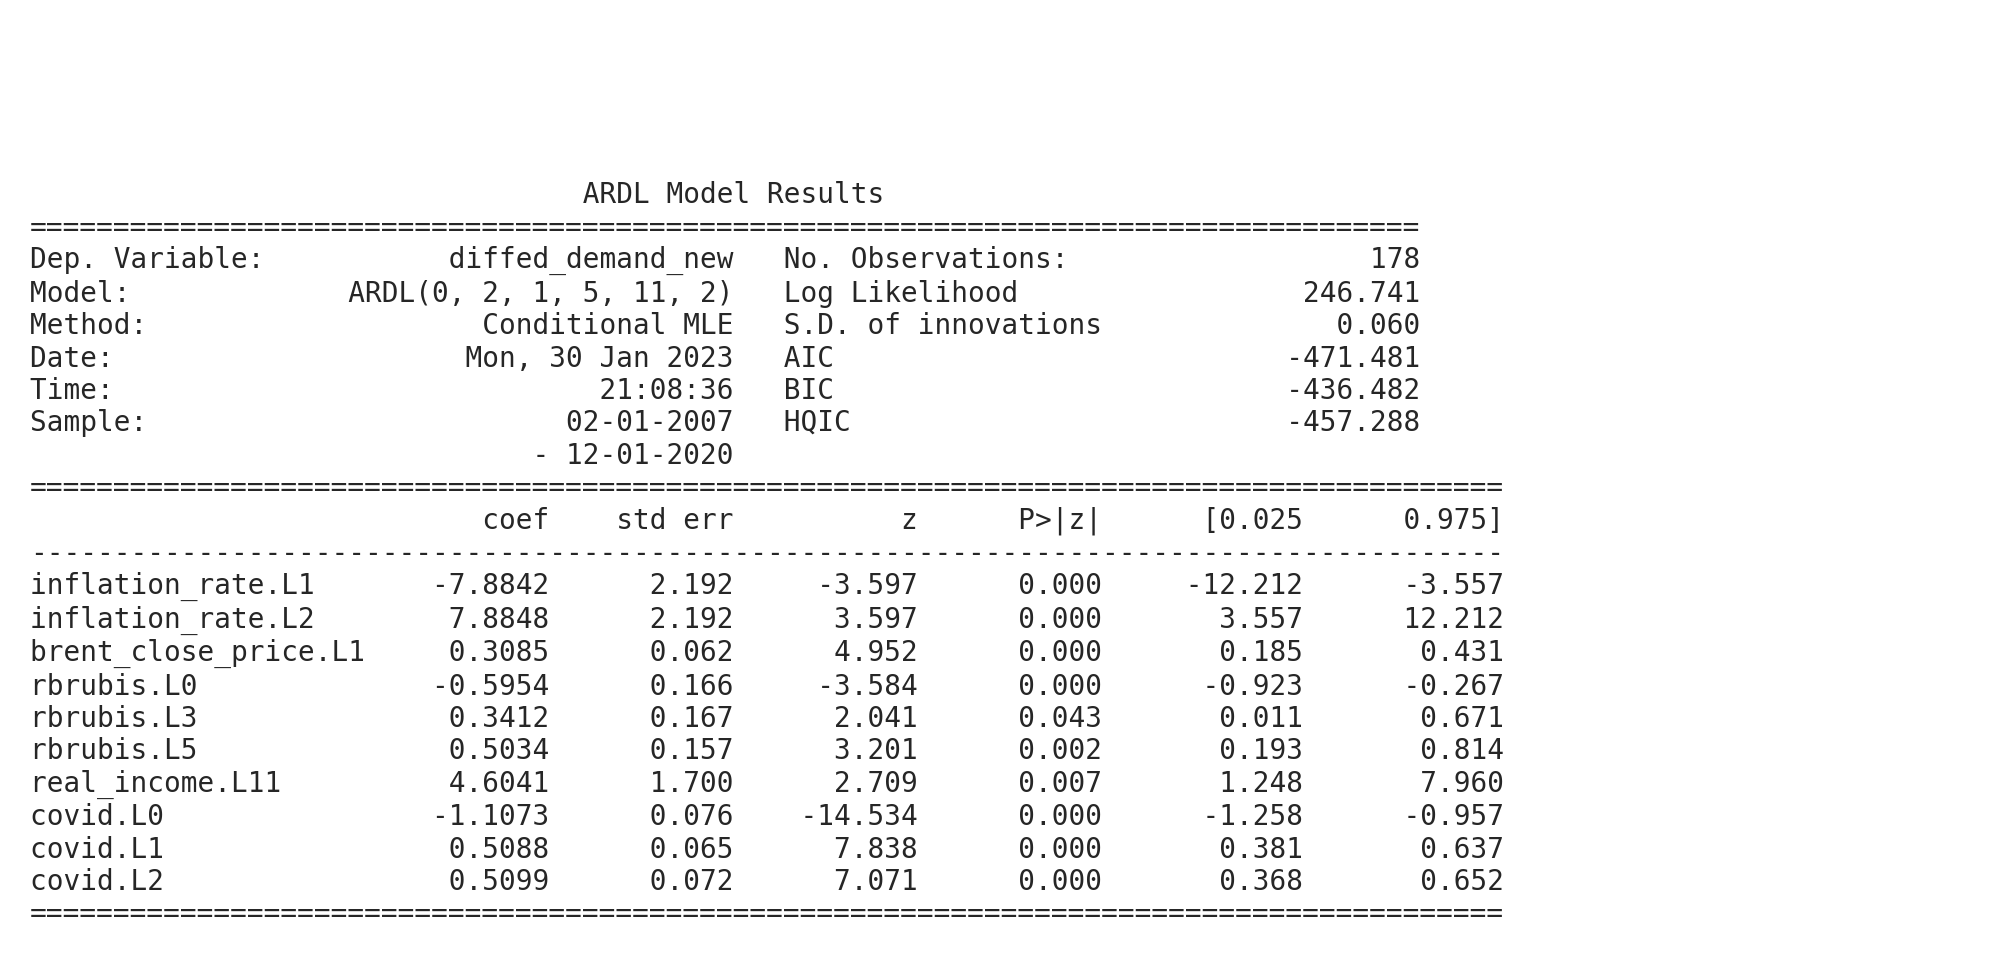

In [85]:
maxlag = 13
lags = {f: [*range(maxlag + 1)] for f in features}
lags['covid'] = [0, 1, 2, 3]

alpha = 0.05
non_significant = True


while non_significant:
    model = ARDL(train['diffed_demand_new'], 0,
               train[features], lags,
               trend='n')
    res = model.fit()

    non_significant = [x[0] for x in res.summary().tables[1].data[1:] if float(x[4]) > alpha]

    if non_significant:
        features_lags = [i[0] for i in res.summary().tables[1].data[1:]]
        p_values = [float(i[4]) for i in res.summary().tables[1].data[1:]]

        most_insig = features_lags[p_values.index(max(p_values))].split('.')

        lags[most_insig[0]].remove(int(most_insig[1][1:]))
        for i in lags.keys():
            if not lags[i]:
                lags.pop(i)
                break


plt.rc('figure', figsize=(20, 10))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 20}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.show()

# pd.DataFrame([x for x in res.summary().tables[1].data[1:]],
#              columns = res.summary().tables[1].data[0])

In [86]:
train_pred = res.predict(start=train.index[0], end=train.index[-1], exog_oos=train[features])
test_pred = res.predict(start=test.index[0], end=test.index[-1], exog_oos=test[features])

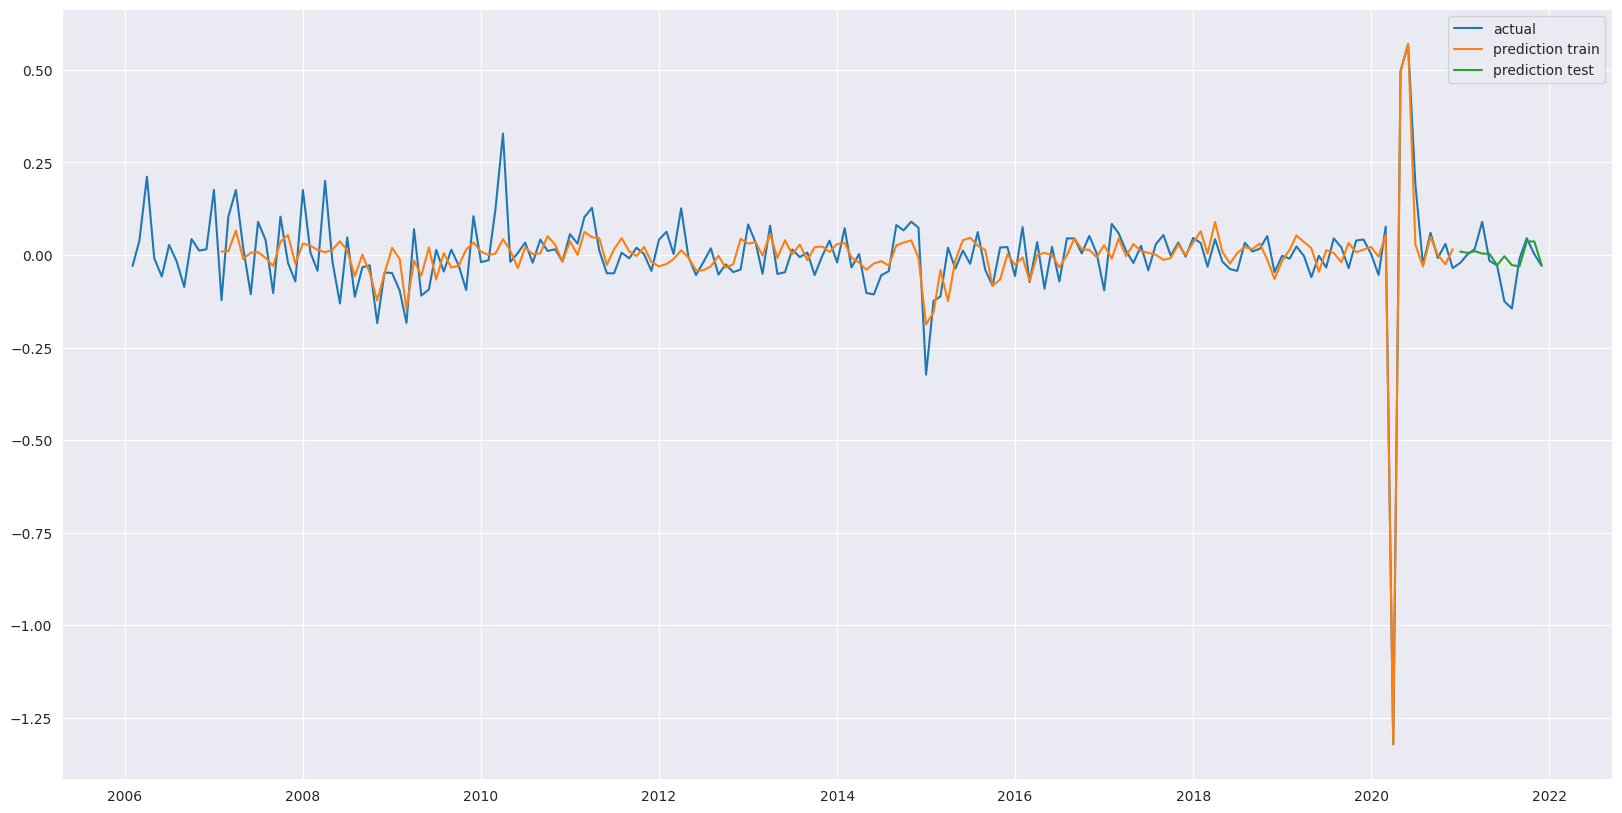

In [87]:
plt.plot(all_df.index, all_df['diffed_demand_new'], label="actual")
plt.plot(train.index, train_pred, label="prediction train")
plt.plot(test.index, test_pred, label="prediction test")
plt.legend()

plt.show()

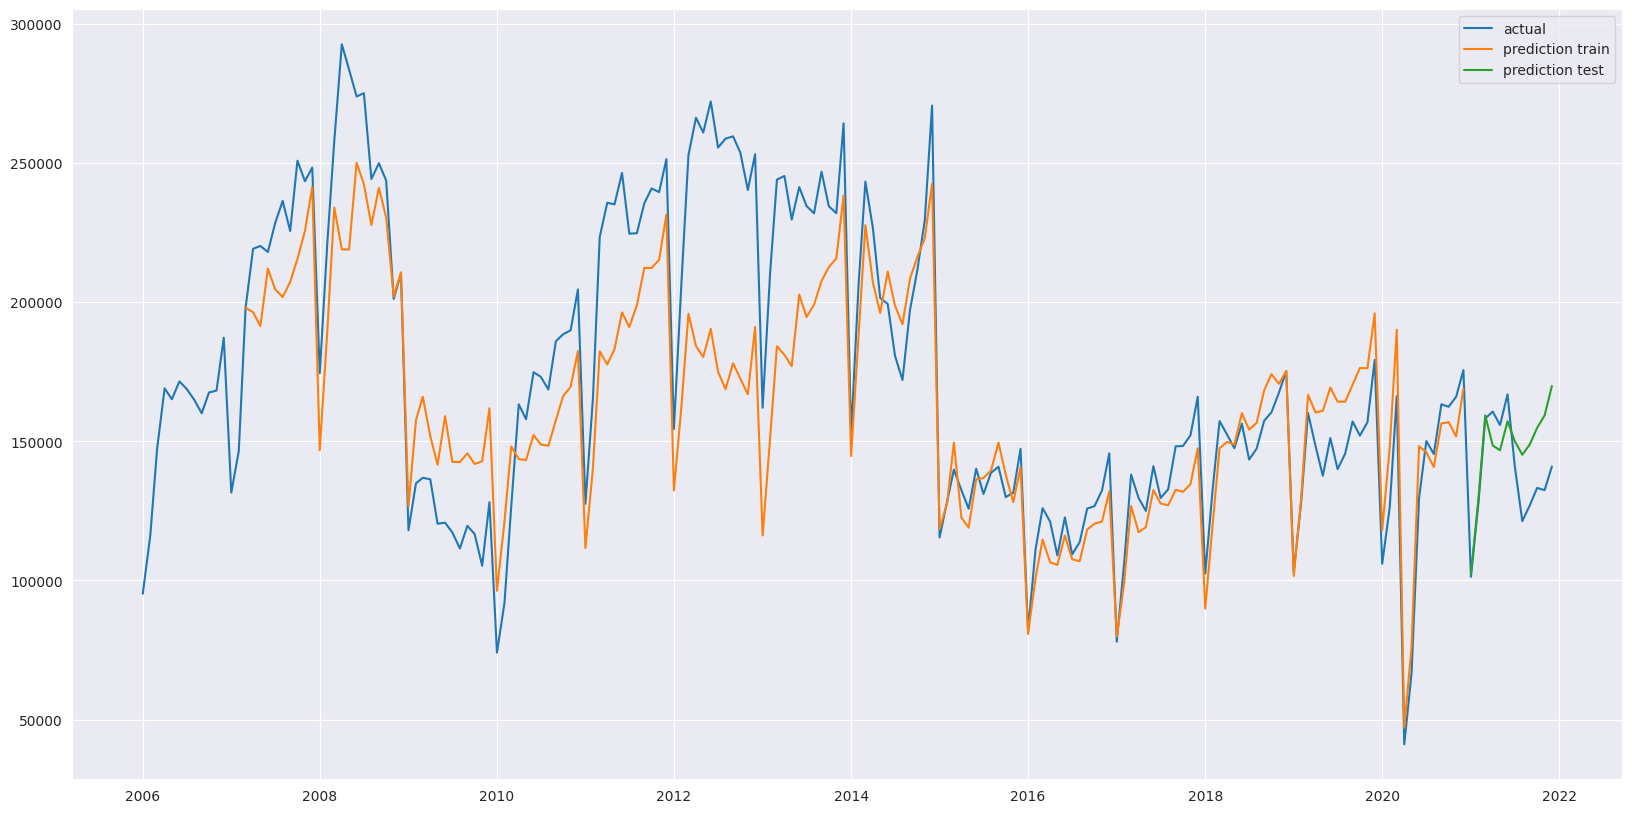

In [88]:
train_first_undiff_value = all_df.iloc[1 + maxlag, ]['deseasonal_demand_new']

prediction_train = train_pred[maxlag:]
prediction_train = np.r_[train_first_undiff_value, prediction_train].cumsum()
prediction_train += all_df.loc[:train.index[-1], 'decompose_result_seasonal'][(1 + maxlag):]
prediction_train = np.exp(prediction_train)

test_first_undiff_value = all_df.loc[all_df.index == pd.to_datetime('2021-01-01'), 'deseasonal_demand_new'][0]

prediction_test = test_pred
prediction_test = np.r_[test_first_undiff_value, prediction_test].cumsum()[1:]
prediction_test += all_df.loc[test.index[0]:, 'decompose_result_seasonal']
prediction_test = np.exp(prediction_test)


plt.plot(all_df.index, all_df['demand_new'], label = "actual")
plt.plot(train.index[(maxlag - 1):], prediction_train, label = "prediction train")
plt.plot(test.index, prediction_test, label = "prediction test")
plt.legend()

plt.show()